# 🦦 HDDOTTER PIPELINE 

## 📦 Import packages

In [1]:
# Get MNE, a python package for brain data analysis
import mne                          # general MNE functions
import mne_nirs                     # specific for NIRS
from mne.viz import set_3d_view     # for 3D plotting
import nibabel as nib               # for handling nifti files

# Handling hdf5-like files
import h5py                         # for handling hdf5 files (generic)
import snirf                        # for handling snirf files (specific for NIRS)

# For testing purposes only
from mne.datasets.testing import data_path 

# Matrix (array) operations
import numpy as np                  # pronounce it "noom-pee" because it's cuter                 

# Some other useful packages
import os.path as op                # for file path operations
import darkdetect                   # adjusts the plots to dark mode if needed
import matplotlib.pyplot as plt     # for general plotting if needed

## 💿 Load the data

### 🧪 Test data
Uncomment the cell below to run.

In [2]:
'''testing_path = data_path(download=True)
fname = op.join(testing_path, 'SNIRF', 'GowerLabs', 'lumomat-1-1-0.snirf')
raw = mne.io.read_raw_snirf(fname, preload=True)'''

"testing_path = data_path(download=True)\nfname = op.join(testing_path, 'SNIRF', 'GowerLabs', 'lumomat-1-1-0.snirf')\nraw = mne.io.read_raw_snirf(fname, preload=True)"

## ፨ SNIRF data
<span style="color:orange">Important:</span> Lumo provides data in .lufr format. First you need to convert it to .snirf in Matlab using the lufr_converter.m script.

In [34]:
# Define the path to the data file (Use relative paths if possible)
snirf_path = 'cecile.snirf'

# This reads the data and displays the main information (Do not touch)
raw = mne.io.read_raw_snirf(snirf_path, preload=True)
raw

Loading /Users/rblc/ELTE/hd_dot/cecile.snirf
Reading 0 ... 5008  =      0.000 ...   400.640 secs...


/var/folders/x2/6gs4vmmn5bxgqplmvj03kx240000gn/T/ipykernel_64310/153996767.py:5: RuntimeWarning: Extraction of measurement date from SNIRF file failed. The date is being set to January 1st, 2000, instead of unknownunknown
  raw = mne.io.read_raw_snirf(snirf_path, preload=True)


<RawSNIRF | cecile.snirf, 3456 x 5009 (400.6 s), ~134.7 MB, data loaded>

In [35]:
raw.get_data().shape

(3456, 5009)

Let's make a rough plot. 

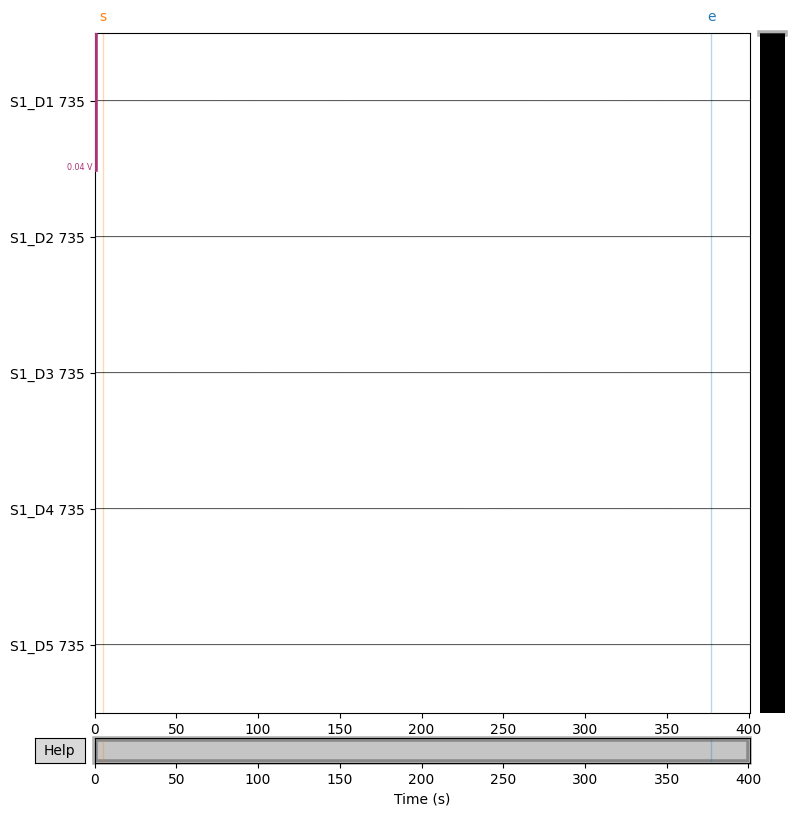

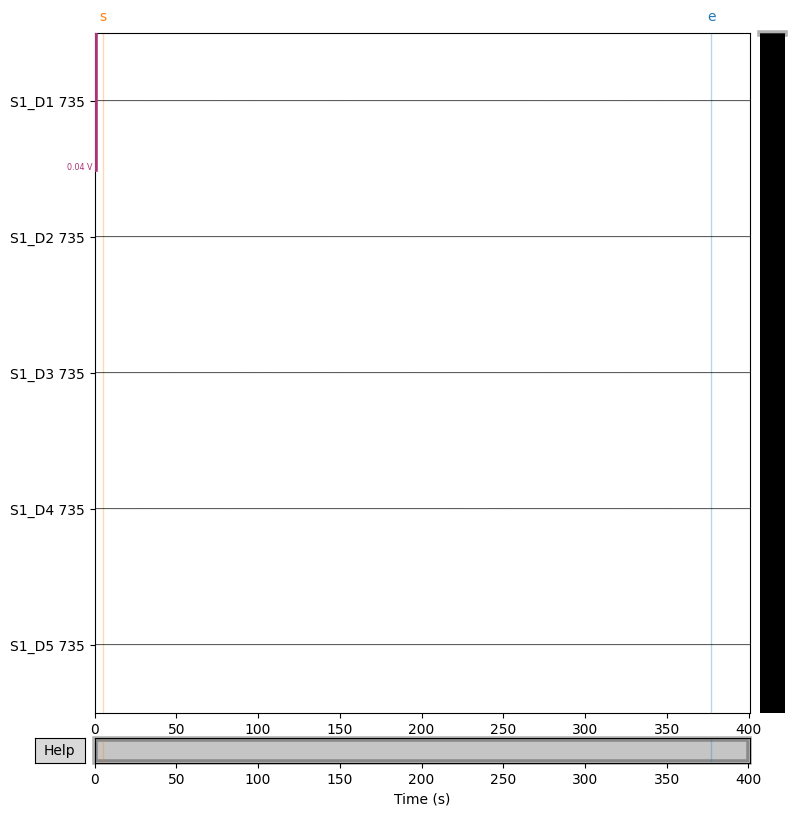

In [36]:
raw.plot(duration=600,          # Set it longer than the measurement, so you see all.
        n_channels=5,           # Look at the first 5 channels only.
        remove_dc=True)         # Remove the DC component from the data.

In [37]:
raw.annotations.to_data_frame()

,onset,duration,description
0,2000-01-01 00:00:05.250,0.0,s
1,2000-01-01 00:06:17.060,0.0,e


<span style='color:yellow'>Things to improve:</span>
- The interactive slider doesn't work in this notebook. Oh well.
- No clue what these codes are (eg. S1_D1).
- I only see the 735 nm channels. I assume the 850 would be below.
- No clue what the DC component removal does. I don't see difference. 

## 🧭 Location related stuff

### 📡 Sensor location
I found the channel locations so far. I have no clue what point coordinates are for a line-like object. Also unsure what the scale is (possibly meters)

In [38]:
for idx, ch in enumerate(raw.info['chs']):
    loc = ch['loc'][:3]                         # First three elements are the x, y, z coordinates
    print(f"Channel {idx}: Location - {loc}")

Channel 0: Location - [0.15855017 0.05463961 0.08029645]
Channel 1: Location - [0.15467324 0.04799847 0.08037023]
Channel 2: Location - [0.15616203 0.05160549 0.08248837]
Channel 3: Location - [0.15526268 0.05217838 0.08679842]
Channel 4: Location - [0.16219246 0.07050485 0.07783027]
Channel 5: Location - [0.16091756 0.06328314 0.08014592]
Channel 6: Location - [0.16145751 0.06758678 0.08109497]
Channel 7: Location - [0.1612625  0.06897235 0.08530873]
Channel 8: Location - [0.15970381 0.08776153 0.07475677]
Channel 9: Location - [0.1613263  0.08052551 0.07679353]
Channel 10: Location - [0.16035682 0.08471054 0.07791568]
Channel 11: Location - [0.16004035 0.08584459 0.08219673]
Channel 12: Location - [0.15315153 0.09638141 0.0939892 ]
Channel 13: Location - [0.15462238 0.09843321 0.08672507]
Channel 14: Location - [0.15489119 0.09545812 0.09000991]
Channel 15: Location - [0.15689967 0.09155974 0.08931547]
Channel 16: Location - [0.16014984 0.07492459 0.09285859]
Channel 17: Location - [

### 💀 Anatomy

Digitization points (digs) are important anatomical landmark points. This I have not yet fully figured out what they are supposed to be in our sample but I found where they are stored. I'm not sure if these stored data are from the LUMO default or Raul gave these names. The previous is more likely.

- **Nasion:** nasion
- **LPA:** left pre-aricular
- **RPA:** right pre-aricular
- **EEG #1:** possibly central zero (Cz)
- **EEG #2:**  possibly inion

In [41]:
# Stored anatomical landmarks (Digitization points)
raw.info['dig']

[<DigPoint |        LPA : (21.2, 94.7, 12.6) mm     : head frame>,
 <DigPoint |     Nasion : (91.2, 199.1, 10.0) mm    : head frame>,
 <DigPoint |        RPA : (170.7, 88.1, 12.6) mm    : head frame>,
 <DigPoint |     EEG #1 : (91.2, 10.0, 10.0) mm     : head frame>,
 <DigPoint |     EEG #2 : (85.7, 89.2, 159.2) mm    : head frame>]

## 🔨 Raw preprocessing

### ✂️ Slice the data

In [42]:
# Find the onset times for 's' and 'e'
annotations = raw.annotations
onset_s = annotations.onset[annotations.description == 's'][0]
onset_e = annotations.onset[annotations.description == 'e'][0]

# Convert times to samples
start_sample = int(onset_s * raw.info['sfreq'])
end_sample = int(onset_e * raw.info['sfreq'])

# Slice the raw object to keep data only between 's' and 'e'
raw_sliced = raw.copy().crop(tmin=start_sample / raw.info['sfreq'], tmax=end_sample / raw.info['sfreq'])

In [43]:
raw_sliced

<RawSNIRF | cecile.snirf, 3456 x 4649 (371.8 s), ~125.2 MB, data loaded>

In [44]:
raw_sliced.get_data().shape

(3456, 4649)

### 🔄 Resample the data
Note that lowpass is Nyquist frequency. It will remain half of the frequency after resampling.

In [45]:
# Define the desired resampling rate in Hz (1 = 1 per second)
resample_rate = 1.0

# Resample the data (Do not touch)
raw_resampled = raw_sliced.resample(resample_rate, npad='auto')
raw_resampled

<RawSNIRF | cecile.snirf, 3456 x 372 (371.0 s), ~12.5 MB, data loaded>

In [46]:
raw_resampled.get_data().shape

(3456, 372)

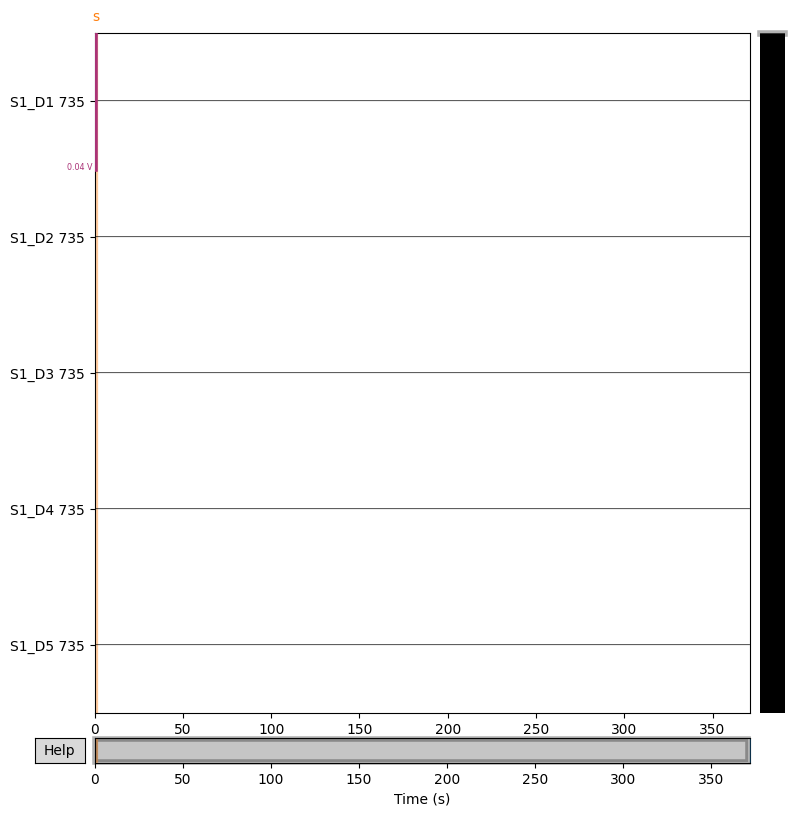

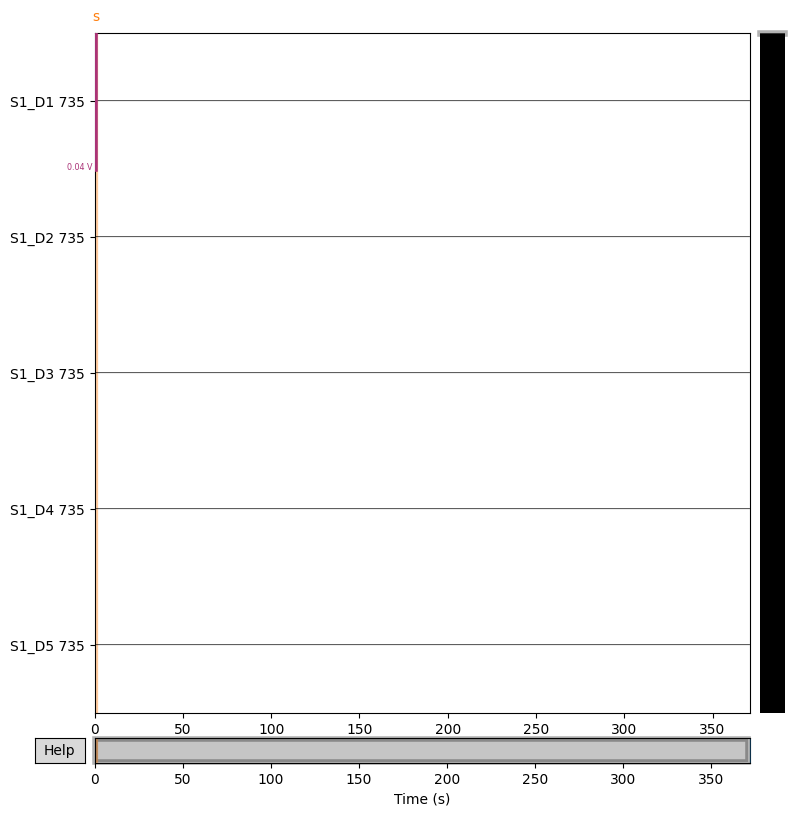

In [47]:
raw_resampled.plot(duration=600,          # Set it longer than the measurement, so you see all.
        n_channels=5,           # Look at the first 5 channels only.
        remove_dc=True)         # Remove the DC component from the data.

Note that the 'start' line is still apparent because annotations are stored as short duration intervals. There's nothing to be worry about.

## 🛝 Sandbox below this line

In [33]:
subjects_dir = op.join(mne.datasets.sample.data_path(), 'subjects')
mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

brain = mne.viz.Brain('fsaverage', subjects_dir=subjects_dir, alpha=0.0, cortex='low_contrast', background="w")
brain.add_sensors(raw.info, trans='fsaverage', fnirs=["sources", "detectors"])
brain.show_view(azimuth=130, elevation=80, distance=700)

0 files missing from root.txt in /Users/rblc/mne_data/MNE-sample-data/subjects
0 files missing from bem.txt in /Users/rblc/mne_data/MNE-sample-data/subjects/fsaverage
Channel types::	fnirs_cw_amplitude: 3456


In [32]:
plot_kwargs = dict(subjects_dir=subjects_dir,
                   surfaces="brain", dig=True, eeg=[],
                   fnirs=['sources', 'detectors'], show_axes=True,
                   coord_frame='head', mri_fiducials=True)

fig = mne.viz.plot_alignment(trans="fsaverage", subject="fsaverage", **plot_kwargs)
set_3d_view(figure=fig, azimuth=90, elevation=0, distance=1)

/var/folders/x2/6gs4vmmn5bxgqplmvj03kx240000gn/T/ipykernel_64310/3778651853.py:6: RuntimeWarning: Digitization points not found. Cannot plot digitization.
  fig = mne.viz.plot_alignment(trans="fsaverage", subject="fsaverage", **plot_kwargs)


In [25]:
fig = mne.viz.plot_alignment(raw.info, trans="fsaverage", subject="fsaverage", **plot_kwargs)
set_3d_view(figure=fig, azimuth=90, elevation=0, distance=1)

Channel types::	fnirs_cw_amplitude: 3456


In [26]:
coreg = mne.coreg.Coregistration(raw.info, "fsaverage", subjects_dir, fiducials="estimated")
coreg.fit_fiducials(lpa_weight=1., nasion_weight=1., rpa_weight=1.)

fig = mne.viz.plot_alignment(raw.info, trans=coreg.trans, subject="fsaverage", **plot_kwargs)
set_3d_view(figure=fig, azimuth=90, elevation=0, distance=1)

Using high resolution head model in /Users/rblc/mne_data/MNE-sample-data/subjects/fsaverage/bem/fsaverage-head-dense.fif
    Triangle neighbors and vertex normals...
Estimating fiducials from fsaverage.
Aligning using fiducials
Start median distance:  71.02 mm
End   median distance:  16.32 mm
Channel types::	fnirs_cw_amplitude: 3456


In [31]:
brain = mne.viz.Brain('fsaverage', subjects_dir=subjects_dir, background='w', cortex='0.5', alpha=0.3)
brain.add_sensors(raw.info, trans=coreg.trans, fnirs=['sources', 'detectors'])
brain.show_view(azimuth=90, elevation=90, distance=500)

Channel types::	fnirs_cw_amplitude: 3456


In [32]:
mtg = raw.get_montage()
mtg.apply_trans(coreg.trans)
raw.set_montage(mtg)

<RawSNIRF | franci.snirf, 3456 x 1232 (98.5 s), ~35.2 MB, data loaded>

In [33]:
mne_nirs.io.write_raw_snirf(raw, "raw_coregistered_to_fsaverage.snirf")

In [35]:
raw_w_coreg = mne.io.read_raw_snirf("raw_coregistered_to_fsaverage.snirf")

# Now you can simply use `trans = "fsaverage"`.
brain = mne.viz.Brain('fsaverage', subjects_dir=subjects_dir, background='w', cortex='0.5', alpha=0.3)
brain.add_sensors(raw_w_coreg.info, trans="fsaverage", fnirs=['sources', 'detectors'])

Loading /Users/rblc/ELTE/hd_dot/raw_coregistered_to_fsaverage.snirf
Channel types::	fnirs_cw_amplitude: 3456
